In [19]:
#X-12-ARIMA季节调整得到趋势循环系列#

import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# 路径设置
input_path = r'D:\智网\多维数据处理\3_用电景气\133行业用电量数据.xlsx'
output_path = r'D:\智网\多维数据处理\3_用电景气\133行业用电量_季调后.xlsx'

# 读取数据（不需要 encoding 参数）
df_raw = pd.read_excel(input_path)

# 提取行业列和时间列
industry_col = df_raw.columns[0]
time_cols = df_raw.columns[1:]

# 将时间列名转换为时间戳索引
time_index = pd.to_datetime(time_cols.astype(str), format='%Y%m')

# 准备存储结果
adjusted_data = []

# 遍历每个行业（按行处理）
for idx, row in df_raw.iterrows():
    industry = row[industry_col]
    series = pd.Series(row[1:].values, index=time_index)

    # 如果有效数据太少就跳过
    if series.isna().sum() > 0 or series.dropna().shape[0] < 24:
        print(f"跳过行业：{industry}，数据不足或存在缺失值")
        adjusted_row = [industry] + [None] * len(time_cols)
    else:
        try:
            decomposition = seasonal_decompose(series, model='additive', period=12, extrapolate_trend='freq')
            seasonally_adjusted = series - decomposition.seasonal
            adjusted_row = [industry] + seasonally_adjusted.tolist()
            print(f"完成：{industry}")
        except Exception as e:
            print(f"失败：{industry}，原因：{e}")
            adjusted_row = [industry] + [None] * len(time_cols)

    adjusted_data.append(adjusted_row)

# 转换为DataFrame
adjusted_df = pd.DataFrame(adjusted_data, columns=[industry_col] + list(time_cols))

# 保存输出
adjusted_df.to_excel(output_path, index=False)
print("✅ 全部完成，结果保存到：", output_path)




完成：全社会用电总计
完成：A、全行业用电合计
完成：    第一产业
完成：    第二产业
完成：    第三产业
完成：B、城乡居民生活用电合计
完成：    城镇居民
完成：    乡村居民
完成：全行业用电分类
完成：一、农、林、牧、渔业
完成：   1.农业
完成：   2.林业
完成：   3.畜牧业
完成：   4.渔业
完成：   5.农、林、牧、渔专业及辅助性活动
完成：      其中：排灌
完成：二、工业
完成：（一）采矿业
完成：    1.煤炭开采和洗选业
完成：    2.石油和天然气开采业
完成：    3.黑色金属矿采选业
完成：    4.有色金属矿采选业
完成：    5.非金属矿采选业
完成：    6.其他采矿活动
完成：（二）制造业
完成：    1.农副食品加工业
完成：    2.食品制造业
完成：    3.酒、饮料及精制茶制造业
完成：    4.烟草制品业
完成：    5.纺织业
完成：    6.纺织服装、服饰业
完成：    7.皮革、毛皮、羽毛及其制品和制鞋业
完成：    8.木材加工和木、竹、藤、棕、草制品业
完成：    9.家具制造业
完成：    10.造纸和纸制品业
完成：    11.印刷和记录媒介复制业
完成：    12.文教、工美、体育和娱乐用品制造业
完成：      其中：体育用品制造
完成：    13.石油、煤炭及其他燃料加工业
完成：      其中：煤化工
完成：    14.化学原料和化学制品制造业
完成：      其中：氯碱
完成：            电石
完成：            黄磷
完成：      其中：肥料制造
完成：    15.医药制造业
完成：      其中：中成药生产
完成：            生物药品制品制造
完成：    16.化学纤维制造业
完成：    17.橡胶和塑料制品业
完成：      其中：橡胶制品业
完成：            塑料制品业
完成：    18.非金属矿物制品业
完成：      其中：水泥制造
完成：            玻璃制造
完成：            陶瓷制品制造
完成：      其中：碳化硅
完成：    19.黑色金属冶炼和压延加工业
完成：      其中：钢铁
完成：     

In [21]:
# 对已季节调整的数据做TPFP三点预测探查法
def tpfp_judge(y1, y2, y3):
    if y1 < y2 < y3:
        return "上升"
    elif y1 > y2 > y3:
        return "下降"
    elif y1 > y2 < y3:
        return "U型"
    elif y1 < y2 > y3:
        return "N型"
    else:
        return "平稳"

# 创建新的 DataFrame 存储TPFP分析结果
tpfp_results = pd.DataFrame()
tpfp_results[industry_col] = adjusted_df[industry_col]

# 遍历时间列，从第3列（对应第3个月）开始处理
for i in range(3, len(time_cols) + 1):
    month = time_cols[i - 1]  # 当前的月份名
    results = []

    for idx, row in adjusted_df.iterrows():
        y1 = row[time_cols[i - 3]]
        y2 = row[time_cols[i - 2]]
        y3 = row[time_cols[i - 1]]
        if pd.isna(y1) or pd.isna(y2) or pd.isna(y3):
            results.append(None)
        else:
            results.append(tpfp_judge(y1, y2, y3))
    
    tpfp_results[month] = results

# 保存TPFP结果
tpfp_output_path = r'D:\智网\多维数据处理\3_用电景气\133行业_TPFP探查结果.xlsx'
tpfp_results.to_excel(tpfp_output_path, index=False)
print("✅ TPFP三点探查完成，结果保存到：", tpfp_output_path)


✅ TPFP三点探查完成，结果保存到： D:\智网\多维数据处理\3_用电景气\133行业_TPFP探查结果.xlsx


In [27]:
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.stats import pearsonr
import concurrent.futures
import logging
import os

# 设置日志记录
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class TPFPAnalyzer:
    """TPFP (时间点-峰值-拟合峰值)分析类，用于计算行业指标与基准的延迟关系"""
    
    def __init__(self, file_path, benchmark_industry="全社会用电量", max_lag=12, 
                 threshold=3, interpolation_points=100, sheet_name=0):
        """
        初始化TPFP分析器
        
        参数:
            file_path (str): 数据文件路径(.xlsx或.csv)
            benchmark_industry (str): 基准行业名称
            max_lag (int): 最大延迟期数
            threshold (int): 先行/滞后的阈值期数
            interpolation_points (int): 插值平滑的点数
            sheet_name: Excel文件的工作表名称或索引(默认为第一个工作表)
        """
        self.file_path = file_path
        self.benchmark_industry = benchmark_industry
        self.max_lag = max_lag
        self.min_lag = -max_lag
        self.threshold = threshold
        self.interpolation_points = interpolation_points
        self.sheet_name = sheet_name
        self.df = None
        self.benchmark_series = None
        
    def load_data(self):
        """加载并准备数据"""
        try:
            # 根据文件扩展名选择读取方法
            file_ext = os.path.splitext(self.file_path)[1].lower()
            
            if file_ext == '.csv':
                self.df = pd.read_csv(self.file_path, index_col=0)
                logger.info(f"从CSV文件加载数据: {self.file_path}")
            elif file_ext in ['.xlsx', '.xls']:
                self.df = pd.read_excel(self.file_path, index_col=0, sheet_name=self.sheet_name)
                logger.info(f"从Excel文件加载数据: {self.file_path}，工作表: {self.sheet_name}")
            else:
                raise ValueError(f"不支持的文件格式: {file_ext}，请使用.csv、.xlsx或.xls文件")
            
            # 检查基准行业是否存在
            if self.benchmark_industry not in self.df.index:
                available_industries = ", ".join(self.df.index)
                raise ValueError(f"基准行业 '{self.benchmark_industry}' 未在数据中找到。"
                               f"可用的行业有: {available_industries}")
            
            self.benchmark_series = self.df.loc[self.benchmark_industry]
            logger.info(f"成功加载数据，共有 {len(self.df)} 个行业，{len(self.df.columns)} 个时间点")
            return True
        except Exception as e:
            logger.error(f"加载数据失败: {str(e)}")
            return False
    
    def compute_correlation(self, industry_series, lag):
        """计算给定延迟下的相关系数"""
        if lag < 0:
            # 先行：行业数据领先基准|lag|期
            x = industry_series[:lag]
            y = self.benchmark_series[-lag:]
        elif lag > 0:
            # 滞后：行业数据滞后基准lag期
            x = industry_series[lag:]
            y = self.benchmark_series[:-lag]
        else:
            x = industry_series
            y = self.benchmark_series
            
        # 确保数据足够计算相关系数
        if len(x) < 2 or len(y) < 2:
            return np.nan
        
        try:
            # 处理可能的NaN值
            valid_mask = ~(np.isnan(x) | np.isnan(y))
            if np.sum(valid_mask) < 2:
                return np.nan
                
            x_valid = x[valid_mask]
            y_valid = y[valid_mask]
            
            corr, _ = pearsonr(x_valid, y_valid)
            return corr
        except Exception as e:
            logger.warning(f"计算相关系数时出错: {str(e)}")
            return np.nan
    
    def tpfp_classification(self, industry_series):
        """
        通过TPFP算法计算行业指标与基准的延迟期数
        
        参数:
            industry_series: 行业用电量时间序列
            
        返回:
            最优延迟期数（负数表示先行，正数表示滞后）
        """
        # 1. 计算原始时差相关系数
        lags = np.arange(self.min_lag, self.max_lag + 1)
        correlations = [self.compute_correlation(industry_series, lag) for lag in lags]
        
        # 2. 处理全部为NaN的情况
        if np.all(np.isnan(correlations)):
            logger.warning(f"行业 {industry_series.name} 与基准的所有相关系数计算结果均为NaN")
            return 0
        
        # 3. 插值平滑（使用三次样条插值）
        valid_indices = ~np.isnan(correlations)
        x = lags[valid_indices]
        y = np.array(correlations)[valid_indices]
        
        # 确保有足够的点进行插值
        if len(x) < 4:  # 三次样条至少需要4个点
            logger.warning(f"行业 {industry_series.name} 有效相关系数点数不足，使用传统方法")
            return lags[np.nanargmax(correlations)]
        
        try:
            # 使用三次样条插值
            f = interpolate.CubicSpline(x, y)
            x_smooth = np.linspace(self.min_lag, self.max_lag, self.interpolation_points)
            y_smooth = f(x_smooth)
            
            # 4. 找到平滑后的最大相关系数对应的延迟期
            optimal_lag = x_smooth[np.argmax(y_smooth)]
            return int(round(optimal_lag))
        except Exception as e:
            logger.warning(f"插值平滑过程出错: {str(e)}，使用传统方法")
            return lags[np.nanargmax(correlations)]
    
    def classify_industry(self, industry):
        """对单个行业进行分类"""
        if industry == self.benchmark_industry:
            return {"行业": industry, "延迟期数": 0, "分类": "一致", "相关系数": 1.0}
        
        industry_series = self.df.loc[industry]
        optimal_lag = self.tpfp_classification(industry_series)
        
        # 计算最大相关系数
        max_corr = self.compute_correlation(industry_series, optimal_lag)
        
        # 根据延迟期数分类
        if optimal_lag < -self.threshold:
            category = "先行"
        elif optimal_lag > self.threshold:
            category = "滞后"
        else:
            category = "一致"
            
        return {
            "行业": industry, 
            "延迟期数": optimal_lag, 
            "分类": category,
            "相关系数": max_corr
        }
    
    def run_analysis(self, use_parallel=True, workers=None):
        """
        运行完整分析流程
        
        参数:
            use_parallel (bool): 是否使用并行处理
            workers (int): 并行处理的工作线程数，None表示使用默认值
            
        返回:
            pandas.DataFrame: 分析结果
        """
        if self.df is None and not self.load_data():
            logger.error("数据未加载，无法进行分析")
            return None
            
        logger.info("开始TPFP分析...")
        industries = self.df.index.tolist()
        
        results = []
        # 并行处理
        if use_parallel and len(industries) > 1:
            with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
                future_to_industry = {
                    executor.submit(self.classify_industry, industry): industry 
                    for industry in industries
                }
                completed = 0
                total = len(industries)
                for future in concurrent.futures.as_completed(future_to_industry):
                    try:
                        result = future.result()
                        results.append(result)
                        completed += 1
                        if completed % max(1, total // 10) == 0:  # 每完成约10%报告一次进度
                            logger.info(f"进度: {completed}/{total} ({completed/total*100:.1f}%)")
                    except Exception as e:
                        industry = future_to_industry[future]
                        logger.error(f"处理行业 {industry} 时出错: {str(e)}")
        else:
            # 顺序处理
            total = len(industries)
            for i, industry in enumerate(industries):
                try:
                    result = self.classify_industry(industry)
                    results.append(result)
                    if (i+1) % max(1, total // 10) == 0:  # 每完成约10%报告一次进度
                        logger.info(f"进度: {i+1}/{total} ({(i+1)/total*100:.1f}%)")
                except Exception as e:
                    logger.error(f"处理行业 {industry} 时出错: {str(e)}")
        
        # 转换为DataFrame并排序
        result_df = pd.DataFrame(results)
        # 按先行/滞后/一致分类排序，再按延迟期数排序
        category_order = {"先行": 0, "一致": 1, "滞后": 2}
        result_df["分类序号"] = result_df["分类"].map(category_order)
        result_df = result_df.sort_values(["分类序号", "延迟期数"])
        result_df = result_df.drop("分类序号", axis=1)
        
        logger.info(f"TPFP分析完成，共分析 {len(result_df)} 个行业")
        return result_df
        
    def save_results(self, result_df, output_path="industry_classification.csv", save_excel=True):
        """
        保存结果到文件
        
        参数:
            result_df: 结果DataFrame
            output_path: 输出文件路径
            save_excel: 是否同时保存为Excel文件
        """
        try:
            # 保存为CSV
            result_df.to_csv(output_path, index=False)
            logger.info(f"结果已保存至CSV: {output_path}")
            
            # 同时保存为Excel
            if save_excel:
                excel_path = os.path.splitext(output_path)[0] + ".xlsx"
                result_df.to_excel(excel_path, index=False, sheet_name="TPFP分析结果")
                logger.info(f"结果已保存至Excel: {excel_path}")
            
            return True
        except Exception as e:
            logger.error(f"保存结果时出错: {str(e)}")
            return False


def main():
    """主函数"""
    # 设置参数
    file_path = r'D:\智网\多维数据处理\3_用电景气\133行业用电量_季调后.xlsx'  # Excel文件路径
    benchmark_industry = "全社会用电总计"
    output_path = r'D:\智网\多维数据处理\3_用电景气\指标划分.xlsx'
    max_lag = 12
    threshold = 3
    sheet_name = 0  # 默认使用第一个工作表，可以指定名称如"Sheet1"
    
    # 创建分析器并运行
    analyzer = TPFPAnalyzer(
        file_path=file_path, 
        benchmark_industry=benchmark_industry,
        max_lag=max_lag,
        threshold=threshold,
        sheet_name=sheet_name
    )
    
    result_df = analyzer.run_analysis(use_parallel=True)
    if result_df is not None:
        analyzer.save_results(result_df, output_path)
        # 输出摘要
        print("\n分类摘要:")
        print(result_df["分类"].value_counts())
        print("\n结果示例:")
        print(result_df.head())


if __name__ == "__main__":
    main()

2025-05-21 16:34:24,661 - INFO - 从Excel文件加载数据: D:\智网\多维数据处理\3_用电景气\133行业用电量_季调后.xlsx，工作表: 0
2025-05-21 16:34:24,661 - INFO - 成功加载数据，共有 133 个行业，27 个时间点
2025-05-21 16:34:24,661 - INFO - 开始TPFP分析...
2025-05-21 16:34:27,038 - INFO - 进度: 13/133 (9.8%)
2025-05-21 16:34:28,148 - INFO - 进度: 26/133 (19.5%)
2025-05-21 16:34:29,107 - INFO - 进度: 39/133 (29.3%)
2025-05-21 16:34:30,009 - INFO - 进度: 52/133 (39.1%)
2025-05-21 16:34:30,700 - INFO - 进度: 65/133 (48.9%)
2025-05-21 16:34:30,700 - INFO - 进度: 78/133 (58.6%)
2025-05-21 16:34:30,700 - INFO - 进度: 91/133 (68.4%)
2025-05-21 16:34:30,700 - INFO - 进度: 104/133 (78.2%)
2025-05-21 16:34:30,700 - INFO - 进度: 117/133 (88.0%)
2025-05-21 16:34:30,700 - INFO - 进度: 130/133 (97.7%)
2025-05-21 16:34:30,737 - INFO - TPFP分析完成，共分析 133 个行业
2025-05-21 16:34:30,754 - INFO - 结果已保存至CSV: D:\智网\多维数据处理\3_用电景气\指标划分.xlsx
2025-05-21 16:34:30,785 - INFO - 结果已保存至Excel: D:\智网\多维数据处理\3_用电景气\指标划分.xlsx



分类摘要:
分类
一致    71
先行    38
滞后    24
Name: count, dtype: int64

结果示例:
                   行业  延迟期数  分类      相关系数
62             其中：碳化硅   -12  先行 -0.133109
90        其中：铁路运输设备制造   -12  先行  0.408010
11         16.化学纤维制造业   -11  先行  0.290737
37              其中：氯碱   -11  先行 -0.104532
49         4.有色金属矿采选业   -11  先行  0.468009


In [64]:
import pandas as pd
import numpy as np
import os

def read_classification_results(classification_file_path):
    print(f"正在读取分类结果文件: {classification_file_path}")
    try:
        df_classification = pd.read_excel(classification_file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"错误: 分类结果文件未找到，请检查路径: {classification_file_path}")
    if '行业' not in df_classification.columns or '分类' not in df_classification.columns:
        raise ValueError("分类结果文件中缺少'行业'或'分类'列。")
    classification_results = df_classification.set_index('行业')['分类'].to_dict()
    print("分类结果读取完成。")
    return classification_results

def read_and_prepare_electricity_data(electricity_data_file_path):
    print(f"正在读取用电量数据文件: {electricity_data_file_path}")
    try:
        df_raw = pd.read_excel(electricity_data_file_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"错误: 用电量数据文件未找到，请检查路径: {electricity_data_file_path}")
    benchmark_row_index = df_raw[df_raw.iloc[:, 0] == '全社会用电总计'].index
    if not benchmark_row_index.empty:
        df_industry_data_raw = df_raw.drop(benchmark_row_index)
        print("已识别并跳过'全社会用电总计'行。")
    else:
        df_industry_data_raw = df_raw.copy()
        print("未找到'全社会用电总计'行，处理所有行作为行业数据。")
    industry_names = df_industry_data_raw.iloc[:, 0].tolist()
    data_columns = df_industry_data_raw.columns[1:]
    df_data = df_industry_data_raw.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
    df_data.index = industry_names
    print("用电量数据准备完成。")
    return df_data, data_columns

def calculate_weights(df_industry_data):
    total = df_industry_data.sum(axis=1)
    return total / total.sum() if total.sum() != 0 else pd.Series(0.0, index=total.index)

def calculate_symmetric_change_rate(series):
    numerator = series - series.shift(1)
    denominator = series + series.shift(1)
    valid_mask = (denominator > 1e-10) & (~pd.isna(denominator))
    change_rate = pd.Series(0.0, index=series.index)
    change_rate[valid_mask] = 200 * numerator[valid_mask] / denominator[valid_mask]
    change_rate.iloc[0] = 0
    return change_rate

def standardize_series(series):
    std = series.std()
    return (series - series.mean()) / std if std != 0 else pd.Series(0.0, index=series.index)

def assign_prosperity_level(di_series):
    def classify(value):
        if pd.isna(value):
            return "缺失"
        elif value >= 95:
            return "一档（非常景气）"
        elif value >= 87.5:
            return "二档（景气）"
        elif value >= 27.21:
            return "三档（正常）"
        elif value >= 9.3:
            return "四档（不景气）"
        else:
            return "五档（非常不景气）"
    return di_series.apply(classify)

# 以下两个函数略——你已提供完整、可运行版本（calculate_composite_index 和 calculate_diffusion_index）
# 为节省篇幅我省略重复代码，确保结构完整性即可

# 请在这里粘贴你原先已实现的 calculate_composite_index(...) 和 calculate_diffusion_index(...)
def calculate_composite_index(df_industry_data, classification_results, weights, data_columns):
    """
    计算先行、一致和滞后组的景气合成指数 (CI)。
    """
    ci_results = pd.DataFrame(index=data_columns)
    
    # 根据分类结果将行业分组
    grouped_industries = {
        '先行': [name for name, cls in classification_results.items() if cls == '先行' and name in df_industry_data.index],
        '一致': [name for name, cls in classification_results.items() if cls == '一致' and name in df_industry_data.index],
        '滞后': [name for name, cls in classification_results.items() if cls == '滞后' and name in df_industry_data.index]
    }

    print(f"行业分组情况:")
    for group_name, industries in grouped_industries.items():
        print(f"  {group_name}: {len(industries)} 个行业")
        if industries:
            print(f"    行业列表: {industries[:5]}{'...' if len(industries) > 5 else ''}")

    V_j_series = {} # 存储每个组的 V_j(t)
    
    # 步骤 1 & 2: 计算对称变化率并标准化 (S_ij(t))
    # 步骤 3: 计算加权平均变化率 (R_j(t))
    for group_name, industries in grouped_industries.items():
        if not industries:
            print(f"警告: {group_name} 组没有匹配的行业数据，跳过CI计算。")
            ci_results[f'{group_name}合成指数'] = np.nan
            continue

        group_data = df_industry_data.loc[industries]
        group_weights = weights.loc[industries]
        
        print(f"\n正在计算 {group_name} 组合成指数...")
        print(f"  组内行业数量: {len(industries)}")
        print(f"  数据时间跨度: {data_columns[0]} 到 {data_columns[-1]}")
        
        # 计算组内每个行业的对称变化率 C_ij(t)
        C_ij_df = group_data.apply(calculate_symmetric_change_rate, axis=1)
        print(f"  对称变化率计算完成，样本范围: {C_ij_df.min().min():.4f} 到 {C_ij_df.max().max():.4f}")
        
        # 标准化 C_ij(t) 得到 S_ij(t)
        S_ij_df = C_ij_df.apply(standardize_series, axis=1)
        print(f"  标准化完成，样本范围: {S_ij_df.min().min():.4f} 到 {S_ij_df.max().max():.4f}")
        
        # 计算 R_j(t) (组的加权平均变化率)
        weighted_S_ij = S_ij_df.multiply(group_weights, axis=0)
        # 检查分母是否为0，避免除以零
        sum_group_weights = group_weights.sum()
        if sum_group_weights == 0:
            R_j_t = pd.Series(0.0, index=data_columns) # 如果权重和为0，则平均变化率为0
        else:
            R_j_t = weighted_S_ij.sum(axis=0) / sum_group_weights
        
        print(f"  加权平均变化率 R_j(t) 范围: {R_j_t.min():.4f} 到 {R_j_t.max():.4f}")
        print(f"  R_j(t) 均值: {R_j_t.mean():.4f}, 标准差: {R_j_t.std():.4f}")
        
        V_j_series[group_name] = R_j_t # 暂时存储 R_j_t，后续会根据 F_j 调整为 V_j(t)

    # 步骤 4: 计算标准化因子 F_j (公式3)
    # F_j = sum(|R_j(t)|) / sum(|R_consistent(t)|)
    consistent_R_t = V_j_series.get('一致')
    if consistent_R_t is None or np.abs(consistent_R_t).sum() == 0:
        print("警告: 无法计算一致指标的R_j(t)或其绝对值总和为零，跳过标准化因子调整。")
        # 如果一致指标有问题，则不进行F_j调整，直接使用R_j(t)作为V_j(t)
        pass 
    else:
        sum_abs_consistent_R = np.abs(consistent_R_t).sum()
        print(f"\n标准化因子计算:")
        print(f"  一致指标 |R_j(t)| 总和: {sum_abs_consistent_R:.4f}")
        for group_name in V_j_series:
            sum_abs_R_j = np.abs(V_j_series[group_name]).sum()
            if sum_abs_consistent_R == 0: # 再次检查分母
                F_j = 1.0 # 如果一致指标总和为0，则不进行缩放
            else:
                F_j = sum_abs_R_j / sum_abs_consistent_R
            print(f"  {group_name} 组标准化因子 F_j: {F_j:.4f}")
            V_j_series[group_name] = V_j_series[group_name] * F_j

    # 步骤 5: 计算初始合成指数 I_j(t) (公式4)
    I_j_initial = {}
    for group_name, V_t in V_j_series.items():
        print(f"\n计算 {group_name} 组初始合成指数...")
        print(f"  V_j(t) 范围: {V_t.min():.4f} 到 {V_t.max():.4f}")
        
        # 修正: 创建一个与 V_t 索引相同的 Series，正确初始化
        I_t = pd.Series(index=V_t.index, dtype=float)
        if not V_t.empty:
            # 修正: 正确赋值第一个元素
            I_t.iloc[0] = 100
            # 从第二个时间点开始递推计算
            for t in range(1, len(V_t)):
                V_value = V_t.iloc[t]
                denominator = 200 - V_value
                if abs(denominator) < 1e-10 or np.isnan(denominator): # 避免除以零或 NaN
                    I_t.iloc[t] = I_t.iloc[t-1] # 保持不变
                else:
                    I_t.iloc[t] = I_t.iloc[t-1] * (200 + V_value) / denominator
                    
                # 调试信息：打印前几个计算步骤
                if t <= 3:
                    print(f"    t={t}: V_t={V_value:.4f}, I_t-1={I_t.iloc[t-1]:.4f}, I_t={I_t.iloc[t]:.4f}")
        
        print(f"  初始合成指数范围: {I_t.min():.4f} 到 {I_t.max():.4f}")
        I_j_initial[group_name] = I_t

    # 步骤 6: 进行趋势调整 (公式5, 6, 7)
    group_growth_rates = {}
    for group_name, V_t in V_j_series.items():
        if V_t.empty:
            group_growth_rates[group_name] = 0
            continue
            
        # 数据期长度检查，假设一个周期为12个月（一年）
        if len(V_t) < 24: # 至少需要2个完整周期（24个月）来计算C_1_mean和C_n_mean
            print(f"警告: {group_name} 组数据长度不足24个月，无法进行趋势调整。跳过趋势调整。")
            group_growth_rates[group_name] = 0 # 设为0表示无调整
            continue
            
        # 确保索引有足够的数据用于计算
        if len(V_t) >= 12:
            C_1_mean = V_t.iloc[:12].mean() # 第一个周期的均值
            C_n_mean = V_t.iloc[-12:].mean() # 最后一个周期的均值
            m_i = len(V_t) // 12 # 完整周期的数量


            # 添加条件判断
            if C_1_mean <= 0 or C_n_mean <= 0 or m_i == 0:
                group_growth_rates[group_name] = 0.0
            else:
                try:
                    r_j = ((C_n_mean / C_1_mean)**(1/m_i) - 1) * 100
                    group_growth_rates[group_name] = r_j
                except:
                    group_growth_rates[group_name] = 0.0
        else:
            group_growth_rates[group_name] = 0.0
           
    # G_r 是一致指标组的平均增长率
    G_r = group_growth_rates.get('一致', 0)

    # 调整 V_j(t) 得到 V_j'(t)
    V_j_adjusted_series = {}
    for group_name, V_t in V_j_series.items():
        r_j = group_growth_rates.get(group_name, 0)
        V_j_adjusted_series[group_name] = V_t + (G_r - r_j)

    # 使用 V_j'(t) 重新计算 I_j(t)
    I_j_adjusted = {}
    for group_name, V_t_adj in V_j_adjusted_series.items():
        # 修正: 创建一个与 V_t_adj 索引相同的 Series，正确初始化
        I_t_adj = pd.Series(index=V_t_adj.index, dtype=float)
        if not V_t_adj.empty:
            # 修正: 正确赋值第一个元素
            I_t_adj.iloc[0] = 100
            # 从第二个时间点开始递推计算
            for t in range(1, len(V_t_adj)):
                denominator = 200 - V_t_adj.iloc[t]
                if denominator == 0 or np.isnan(denominator): # 避免除以零或 NaN
                    I_t_adj.iloc[t] = I_t_adj.iloc[t-1] # 保持不变
                else:
                    I_t_adj.iloc[t] = I_t_adj.iloc[t-1] * (200 + V_t_adj.iloc[t]) / denominator
        I_j_adjusted[group_name] = I_t_adj

# 步骤 7: 直接输出调整后的趋势指数 I'_j(t)，不做归一化
    for group_name, I_t_adj in I_j_adjusted.items():
        if I_t_adj.empty:
            ci_results[f'{group_name}合成指数'] = np.nan
        else:
     # 直接使用趋势调整后的合成指数，无归一化处理
            ci_results[f'{group_name}合成指数'] = I_t_adj
            
    return ci_results
                
def calculate_diffusion_index(df_industry_data, classification_results, data_columns):
    """
    计算先行、一致和滞后组的景气扩散指数 (DI)。
    """
    di_results = pd.DataFrame(index=data_columns)

    grouped_industries = {
        '先行': [name for name, cls in classification_results.items() if cls == '先行' and name in df_industry_data.index],
        '一致': [name for name, cls in classification_results.items() if cls == '一致' and name in df_industry_data.index],
        '滞后': [name for name, cls in classification_results.items() if cls == '滞后' and name in df_industry_data.index]
    }

    for group_name, industries in grouped_industries.items():
        if not industries:
            print(f"警告: {group_name} 组没有匹配的行业数据，跳过DI计算。")
            di_results[f'{group_name}扩散指数'] = np.nan
            continue

        group_data = df_industry_data.loc[industries]
        
        # 计算每个行业用电量的3个月滑动平均值
        # .T 转置使时间序列成为行，然后应用 rolling，再转置回来
        rolling_avg_df = group_data.T.rolling(window=3, min_periods=1).mean().T 
        
        # X_i_df 存储每个行业在每个时间点是否扩张 (1) 或收缩 (0)
        X_i_df = pd.DataFrame(0, index=group_data.index, columns=group_data.columns)
        
        # 从第二个时间点开始比较，因为需要"上一期"的滑动平均
        for col_idx in range(1, len(data_columns)): 
            current_month = data_columns[col_idx]
            previous_month = data_columns[col_idx - 1]
            
            # 获取当前月和上一个月的3个月滑动平均值
            current_period_avg = rolling_avg_df[current_month]
            previous_period_avg = rolling_avg_df[previous_month]
            
            # 判断是否扩张：当前期3个月滑动平均值 > 上一期3个月滑动平均值
            # .fillna(False) 处理因 rolling 窗口不足导致的 NaN，将其视为不扩张
            comparison = (current_period_avg > previous_period_avg).fillna(False) 
            X_i_df[current_month] = comparison.astype(int)

        # 计算组的扩散指数 (公式8)
        num_industries_in_group = len(industries)
        if num_industries_in_group == 0:
            di_results[f'{group_name}扩散指数'] = np.nan
        else:
            # X_i_df.sum(axis=0) 得到每个时间点扩张的行业数量
            di_results[f'{group_name}扩散指数'] = (X_i_df.sum(axis=0) / num_industries_in_group) * 100
            
    return di_results
# ----------主流程入口----------

def main_prosperity_index_calculation(electricity_data_file_path, classification_file_path):
    print("开始编制景气指数...")
    try:
        classification_results = read_classification_results(classification_file_path)
        df_industry_data, data_columns = read_and_prepare_electricity_data(electricity_data_file_path)
        common_industries = list(set(df_industry_data.index) & set(classification_results.keys()))
        df_industry_data = df_industry_data.loc[common_industries]
        classification_results = {k: v for k, v in classification_results.items() if k in common_industries}

        if df_industry_data.empty:
            print("错误: 没有匹配的行业数据用于景气指数计算。")
            return None, None

        print(f"共有 {len(common_industries)} 个行业数据和分类结果匹配，将用于计算。")
        weights = calculate_weights(df_industry_data)
        print("行业权重计算完成。")

        ci_df = calculate_composite_index(df_industry_data, classification_results, weights, data_columns)
        print("合成指数计算完成。")

        di_df = calculate_diffusion_index(df_industry_data, classification_results, data_columns)
        print("扩散指数计算完成。")

        # 添加预警等级列
        if '先行扩散指数' in di_df.columns:
            di_df['景气等级'] = assign_prosperity_level(di_df['先行扩散指数'])
            print("已根据先行扩散指数添加景气等级列。")
        else:
            print("警告：未找到'先行扩散指数'列，无法添加景气等级。")

        # 输出到输入路径目录下
        output_dir = os.path.dirname(electricity_data_file_path)
        ci_path = os.path.join(output_dir, "合成指数.xlsx")
        di_path = os.path.join(output_dir, "diffusion_index_results.xlsx")
        di_level_path = os.path.join(output_dir, "diffusion_index_with_levels.xlsx")

        ci_df.to_excel(ci_path)
        di_df.drop(columns=['景气等级'], errors='ignore').to_excel(di_path)
        di_df.to_excel(di_level_path)

        print(f"合成指数结果已保存至: {ci_path}")
        print(f"扩散指数结果已保存至: {di_path}")
        print(f"含预警等级的扩散指数结果已保存至: {di_level_path}")
        print("景气指数编制完成。")
        return ci_df, di_df

    except Exception as e:
        print(f"景气指数计算过程中发生错误: {e}")
        import traceback
        print(traceback.format_exc())
        return None, None

# ----------运行入口----------

if __name__ == "__main__":
    electricity_data_file = r'D:\智网\多维数据处理\3_用电景气\133行业用电量_季调后.xlsx'
    classification_file = r'D:\智网\多维数据处理\3_用电景气\指标划分.xlsx'
    ci_results_df, di_results_df = main_prosperity_index_calculation(
        electricity_data_file, classification_file
    )
    if ci_results_df is not None and di_results_df is not None:
        print("\n合成指数结果预览 (前5行):")
        print(ci_results_df.head())
        print("\n扩散指数 + 预警等级预览 (前5行):")
        print(di_results_df.head())


开始编制景气指数...
正在读取分类结果文件: D:\智网\多维数据处理\3_用电景气\指标划分.xlsx
分类结果读取完成。
正在读取用电量数据文件: D:\智网\多维数据处理\3_用电景气\133行业用电量_季调后.xlsx
已识别并跳过'全社会用电总计'行。
用电量数据准备完成。
共有 132 个行业数据和分类结果匹配，将用于计算。
行业权重计算完成。
行业分组情况:
  先行: 38 个行业
    行业列表: ['      其中：碳化硅', '      其中：铁路运输设备制造', '    16.化学纤维制造业', '      其中：氯碱', '    4.有色金属矿采选业']...
  一致: 70 个行业
    行业列表: ['   1.电信、广播电视和卫星传输服务', '   5.农、林、牧、渔专业及辅助性活动', '      其中：煤化工', '    14.化学原料和化学制品制造业', '   5.管道运输业']...
  滞后: 24 个行业
    行业列表: ['            铁合金冶炼', '            黄磷', '      其中：互联网数据服务', '    10.造纸和纸制品业', '    18.非金属矿物制品业']...

正在计算 先行 组合成指数...
  组内行业数量: 38
  数据时间跨度: 202301 到 202503
  对称变化率计算完成，样本范围: -525.8636 到 173.5449
  标准化完成，样本范围: -4.1798 到 3.3801
  加权平均变化率 R_j(t) 范围: -1.8445 到 1.3150
  R_j(t) 均值: 0.0000, 标准差: 0.5810

正在计算 一致 组合成指数...
  组内行业数量: 70
  数据时间跨度: 202301 到 202503
  对称变化率计算完成，样本范围: -191.2190 到 146.2909
  标准化完成，样本范围: -3.4078 到 3.7209
  加权平均变化率 R_j(t) 范围: -2.4112 到 2.4533
  R_j(t) 均值: 0.0000, 标准差: 0.8012

正在计算 滞后 组合成指数...
  组内行业数量: 24
  数据时间跨度: 202301 到 

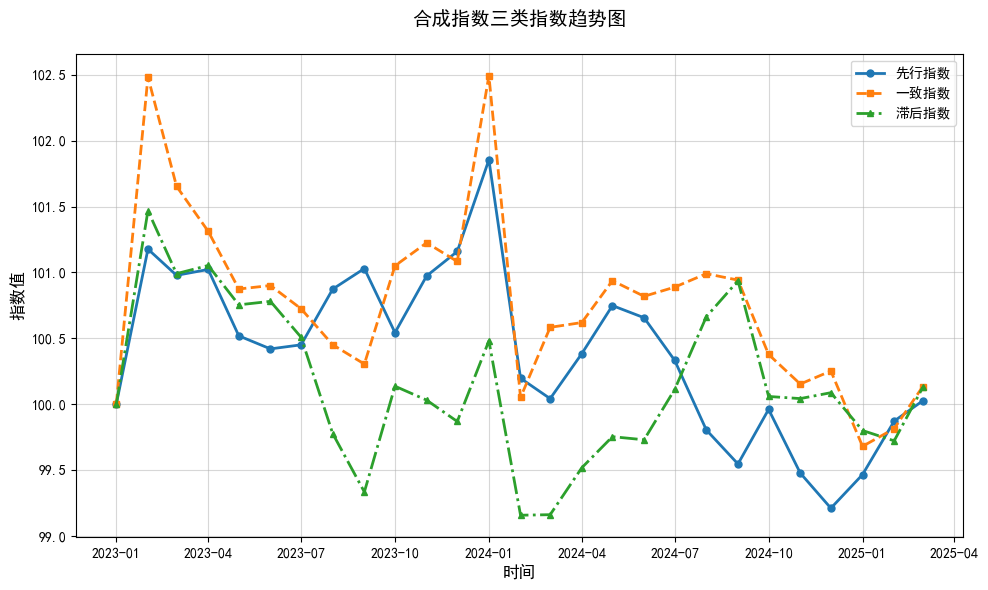

成功生成：D:\智网\多维数据处理\3_用电景气\合成指数_趋势图.png


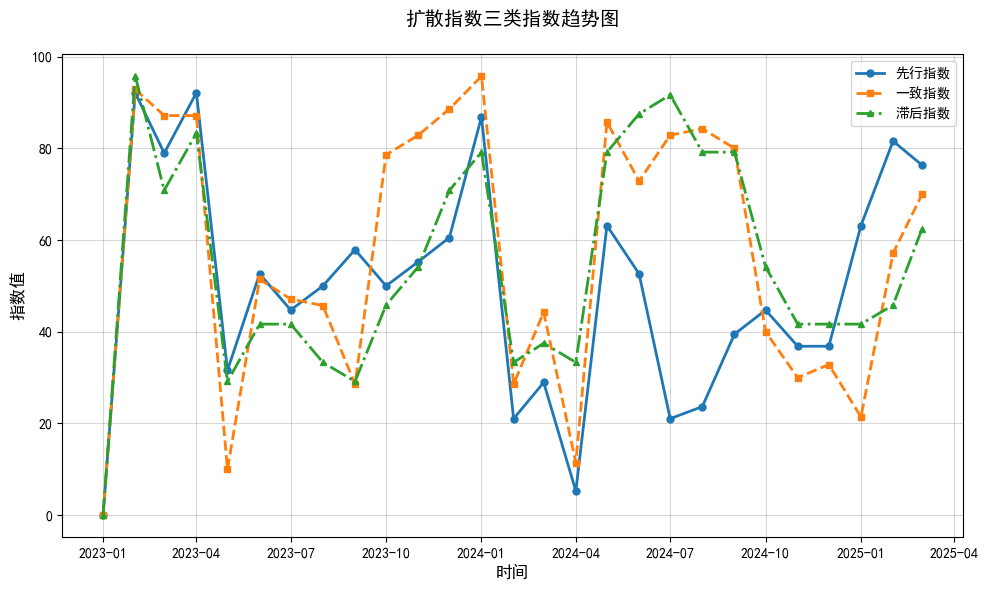

成功生成：D:\智网\多维数据处理\3_用电景气\扩散指数_趋势图.png


In [80]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 设置全局中文字体和解决负号显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def read_index(file_path):
    """
    读取指数文件，格式为：
    第一列：年月(格式：202301)
    后三列：三类指数（先行、一致、滞后）
    返回DataFrame，索引为时间类型。
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"文件不存在：{file_path}")

    df = pd.read_excel(file_path, header=None, sheet_name=0)  # 确保读取第一个工作表
    df.columns = ['年月', '先行指数', '一致指数', '滞后指数']

    # 提取年月并转换为datetime
    df['年月'] = df['年月'].astype(str).str.extract(r'(\d{6})')[0]
    df['年月'] = pd.to_datetime(df['年月'], format='%Y%m', errors='coerce')  # 处理无效日期

    # 转换数值列并处理无效值
    for col in ['先行指数', '一致指数', '滞后指数']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(subset=['年月'], inplace=True)  # 删除无效日期行
    df.set_index('年月', inplace=True)
    df.sort_index(inplace=True)  # 按时间排序
    return df

def plot_trends(df, title, save_path):
    plt.figure(figsize=(10,6))
    plt.plot(df.index, df['先行指数'], label='先行指数', marker='o', linestyle='-', linewidth=2, markersize=5)
    plt.plot(df.index, df['一致指数'], label='一致指数', marker='s', linestyle='--', linewidth=2, markersize=5)
    plt.plot(df.index, df['滞后指数'], label='滞后指数', marker='^', linestyle='-.', linewidth=2, markersize=5)
    
    plt.xlabel('时间', fontsize=12)
    plt.ylabel('指数值', fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    
    # 先保存再显示
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()  # 新增显示功能
    plt.close()
    
def main():
    base_path = r'D:\智网\多维数据处理\3_用电景气'
    files_config = [
        ('合成指数.xlsx', '合成指数_趋势图.png', '合成指数三类指数趋势图'),
        ('扩散指数.xlsx', '扩散指数_趋势图.png', '扩散指数三类指数趋势图')
    ]

    for file_name, save_name, title in files_config:
        file_path = os.path.join(base_path, file_name)
        save_path = os.path.join(base_path, save_name)
        try:
            df = read_index(file_path)
            plot_trends(df, title, save_path)
            print(f"成功生成：{save_path}")
        except Exception as e:
            print(f"处理文件 {file_name} 时出错：{str(e)}")

if __name__ == '__main__':
    main()

正在处理文件：合成指数.xlsx


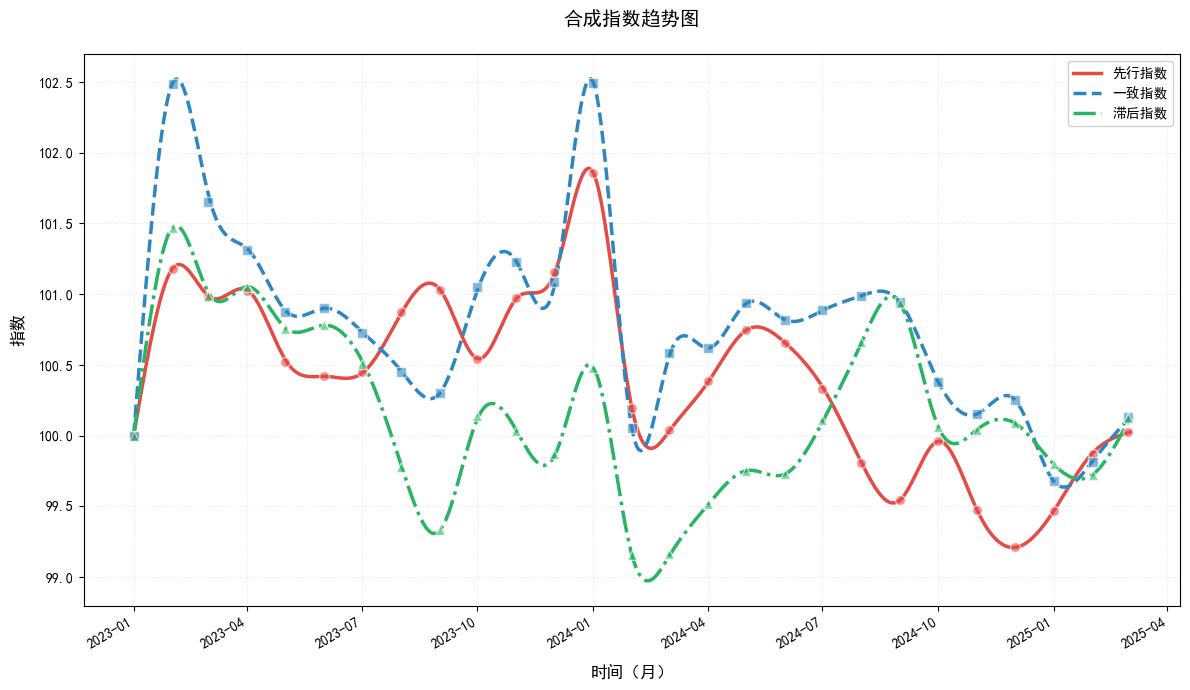

成功生成：合成指数_曲线图.png

正在处理文件：扩散指数.xlsx


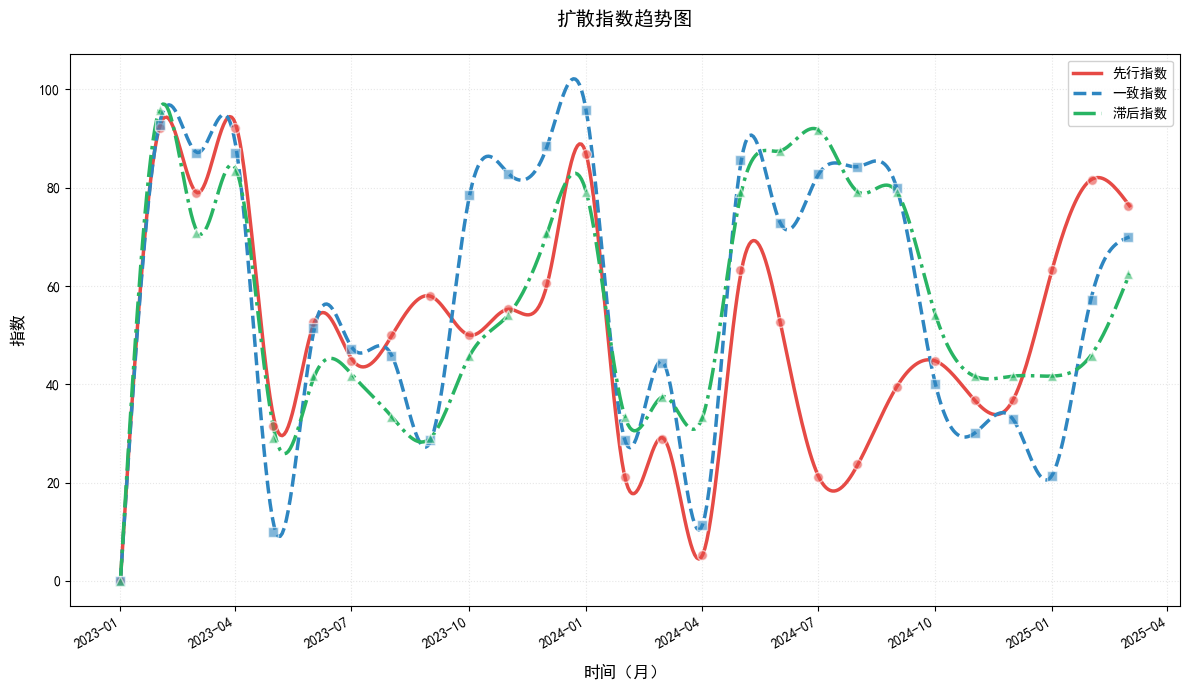

成功生成：扩散指数_曲线图.png



In [90]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from datetime import timedelta

# 设置中文字体（Windows系统使用SimHei，Mac系统使用Arial Unicode MS）
plt.rcParams['font.sans-serif'] = ['SimHei'] if os.name == 'nt' else ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def read_index(file_path):
    """
    读取并预处理指数数据文件
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"文件不存在：{file_path}")

    # 读取原始数据
    df = pd.read_excel(file_path, header=None, sheet_name=0)
    df.columns = ['年月', '先行指数', '一致指数', '滞后指数']
    
    # 预处理日期列
    df['年月'] = (
        df['年月']
        .astype(str)
        .str.extract(r'(\d{6})', expand=False)
        .apply(lambda x: pd.to_datetime(x, format='%Y%m', errors='coerce'))
    )
    # 处理数值列
    numeric_cols = ['先行指数', '一致指数', '滞后指数']
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    
    # 清理数据
    df = df.dropna(subset=['年月'] + numeric_cols, how='all')
    df = df.set_index('年月').sort_index()
    
    # 前向填充缺失值（可根据需要修改为其他填充方式）
    df[numeric_cols] = df[numeric_cols].ffill()
    
    return df

def plot_smooth_curves(df, title, save_path):
    """
    绘制带三次样条插值的平滑曲线图
    """
    plt.figure(figsize=(12, 7))
    
    # 创建插值基础
    time_points = np.arange(len(df.index))
    time_new = np.linspace(0, len(df.index)-1, 500)  # 插值点数量
    
    # 颜色和样式配置
    styles = {
        '先行指数': {'color': '#E64A45', 'ls': '-', 'marker': 'o'},
        '一致指数': {'color': '#2E86C1', 'ls': '--', 'marker': 's'},
        '滞后指数': {'color': '#28B463', 'ls': '-.', 'marker': '^'}
    }
    
    for col in ['先行指数', '一致指数', '滞后指数']:
        # 原始数据点
        plt.scatter(
            df.index,
            df[col],
            c=styles[col]['color'],
            marker=styles[col]['marker'],
            s=50,
            alpha=0.6,
            edgecolors='w',
            zorder=3
        )
        
        # 三次样条插值
        cs = CubicSpline(time_points, df[col], bc_type='natural')
        y_new = cs(time_new)
        
        # 转换为时间序列
        time_deltas = [df.index[0] + timedelta(days=x*30.44) for x in time_new]
        
        # 绘制平滑曲线
        plt.plot(
            time_deltas,
            y_new,
            linestyle=styles[col]['ls'],
            linewidth=2.5,
            color=styles[col]['color'],
            label=col,
            zorder=2
        )
    
    # 图表装饰
    plt.xlabel('时间（月）', fontsize=12, labelpad=10)
    plt.ylabel('指数', fontsize=12, labelpad=10)
    '''
    plt.title(f'{title}\n（三次样条插值平滑处理）', fontsize=14, pad=20)
    '''
    plt.title(f'{title}', fontsize=14, pad=20) 
    plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle=':')
    
    # 优化时间轴显示
    plt.gca().xaxis.set_major_formatter(
        plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate(rotation=30)
    plt.tight_layout()
    
    # 保存和显示
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def main():
    base_path = r'D:\智网\多维数据处理\3_用电景气'
    
    # 定义处理任务
    tasks = [
        {
            'input': '合成指数.xlsx',
            'output': '合成指数_曲线图.png',
            'title': '合成指数趋势图'
        },
        {
            'input': '扩散指数.xlsx',
            'output': '扩散指数_曲线图.png',
            'title': '扩散指数趋势图'
        }
    ]
    
    for task in tasks:
        try:
            file_path = os.path.join(base_path, task['input'])
            save_path = os.path.join(base_path, task['output'])
            
            print(f"正在处理文件：{task['input']}")
            df = read_index(file_path)
            
            if df.empty:
                print(f"警告：{task['input']} 无有效数据")
                continue
                
            plot_smooth_curves(df, task['title'], save_path)
            print(f"成功生成：{task['output']}\n")
            
        except Exception as e:
            print(f"处理 {task['input']} 时发生错误：{str(e)}\n")

if __name__ == '__main__':
    main()